In [10]:
# Установка и импорт необходимых библиотек
# pip install pandas, numpy, sklearn, seaborn
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score

In [11]:
# Начало войны с отсутствующими данными!
titanic_origin = pd.read_csv("titanic.csv")
titanic_origin.isnull().sum()  # Количество пропусков

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [12]:
# Создаём таблицу, что бы найти оптимальную глубину дерева
scores_data = pd.DataFrame({'max_depth': [], 'train_score': [], 'test_score': [], "mistake_5": [], "mistake_10": []})

titanic = pd.read_csv("titanic.csv") # Загружаем таблицу

titanic = titanic.assign(passenger_id=range(titanic.shape[0])) # Создаём id пассажирам

titanic_for_ml_age = titanic.copy()  # Копируем табличку

# Подготавливаем данные для машинного обучения. Удаляем лишние значения, заменяем текстовые на числовые
titanic_for_ml_age.sex = titanic_for_ml_age.sex.replace(["male", "female"], [0, 1])
titanic_for_ml_age = titanic_for_ml_age.drop(["class", "deck", "embarked", "alive", "fare", "embark_town"], axis=1)
titanic_for_ml_age.who = titanic_for_ml_age.who.replace(["man", "woman", "child"], [0, 1, 2])

# Всё float надо было преобразовать в int, так как дерево с данным методом обучения не оценивает значения с точкой
titanic_for_ml_age.who = titanic_for_ml_age.who.apply(int)
titanic_for_ml_age.adult_male = titanic_for_ml_age.adult_male.apply(int)

titanic_for_test_age = titanic_for_ml_age.loc[titanic_for_ml_age.age.isnull()]  # Забираем данные, в которых надо возраст найти

titanic_for_test_age = titanic_for_test_age.drop(["age"], axis=1)  # Удаляем колонку с возрастами

titanic_for_ml_age = titanic_for_ml_age.dropna()  # Удаляем строки с отсутствующими возрастами

titanic_for_ml_age.age = titanic_for_ml_age.age.apply(int)

# Создаём данные для тренировки нейронной сети
X_titanic_age = titanic_for_ml_age.drop(["age"], axis=1)
y_titanic_age = titanic_for_ml_age.age

C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\385179096.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score, "mistake_5": mistake_5,
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\385179096.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score, "mistake_5": mistake_5,
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\385179096.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score, "mistake_5": mis

<AxesSubplot:xlabel='max_depth', ylabel='score'>

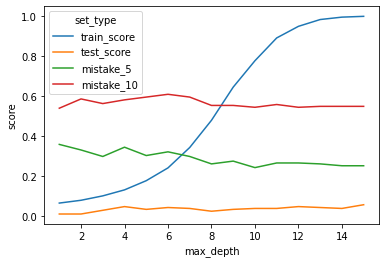

In [13]:
# Разбиваем данные для тренировки и проверки модели
X_titanic_train_age, X_titanic_test_age, y_titanic_train_age, y_titanic_test_age = train_test_split(X_titanic_age, y_titanic_age, test_size=0.3, random_state=10)

for max_depth in range(1, 16):
    titanic_tree_age = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth) # Создаём

    titanic_tree_age.fit(X_titanic_train_age, y_titanic_train_age)  # Тренируем
    train_score = titanic_tree_age.score(X_titanic_train_age, y_titanic_train_age) # Тестируем

    test_score = titanic_tree_age.score(X_titanic_test_age, y_titanic_test_age)  # Результат угадывания возраста с идеальной точностью

    ages = list(titanic_tree_age.predict(X_titanic_test_age))

    mistake_5 = 0
    for i in range(X_titanic_test_age.shape[0]):
        if y_titanic_test_age.iloc[i] - 5 < ages[i] < y_titanic_test_age.iloc[i] + 5:
            mistake_5 += 1
    mistake_5 /= X_titanic_test_age.shape[0]  # Результат угадывания возраста с погрешностью в +- 5 лет

    mistake_10 = 0
    for i in range(X_titanic_test_age.shape[0]):
        if y_titanic_test_age.iloc[i] - 10 < ages[i] < y_titanic_test_age.iloc[i] + 10:
            mistake_10 += 1
    mistake_10 /= X_titanic_test_age.shape[0]  # Результат угадывания возраста с погрешностью в +- 10 лет

    scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score, "mistake_5": mistake_5,
                                      "mistake_10": mistake_10}, ignore_index=True)

# Преобразуем данные для красивой таблички
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', "mistake_5", "mistake_10"], var_name="set_type", value_name="score")
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long) # Рисуем красивую табличку

In [14]:
titanic_tree_age = tree.DecisionTreeClassifier(criterion="entropy", max_depth=6)  # Создаём модель с максимальной эффективностью

titanic_tree_age.fit(X_titanic_age, y_titanic_age)  # Скармливаем весь доступный датасет, ведь чем больше данных, тем точнее предсказание

titanic_for_test_age["age"] = list(titanic_tree_age.predict(titanic_for_test_age))  # Находим утерянные возраста людей

titanic_2 = titanic.copy()  # Копируем датасет оригинальный для мёрджа

# Всю эту лабуду можно сделать и проще, но я не нашёл как
titanic_2 = titanic_2.merge(titanic_for_test_age[["passenger_id", "age"]], on="passenger_id", how="left")
titanic.age.where(~(titanic.age.isnull()), other=titanic_2.age_y, inplace=True)

In [15]:
print(titanic.isnull().sum(), "\n\n")  # Проверяем, что всё у нас круто и вообще мы молодцы

# Сравниваем отсутствие огромных различий в получившихся результатах
titanic_original =  pd.read_csv("titanic.csv")
print("Различие среднего возраста пассажиров:", titanic_original.age.mean() - titanic.age.mean())
print("Различие медианного возраста:", titanic_original.age.median() - titanic.age.median())

survived          0
pclass            0
sex               0
age               0
sibsp             0
parch             0
fare              0
embarked          2
class             0
who               0
adult_male        0
deck            688
embark_town       2
alive             0
alone             0
passenger_id      0
dtype: int64 


Различие среднего возраста пассажиров: 0.9626754472832886
Различие медианного возраста: 2.0


In [16]:
# После заполнения возрастов было бы недурно заполнить и палубы

# Опять создаём таблицу, что бы найти оптимальную глубину дерева
scores_data = pd.DataFrame({'max_depth': [], 'train_score': [], 'test_score': [], "mean_cross_val_score": []})

titanic_for_ml_deck = titanic.copy()  # Копируем табличку

# Подготавливаем данные для машинного обучения. Удаляем лишние значения, заменяем текстовые на числовые
titanic_for_ml_deck = titanic_for_ml_deck.drop(["class", "embark_town", "alive", "age", "sibsp", "who", "adult_male", "parch"], axis=1)

titanic_for_ml_deck = titanic_for_ml_deck[titanic_for_ml_deck.embarked.notna()]  # Удаляем два предательски отсутствующих города отправления

titanic_for_ml_deck.sex = titanic_for_ml_deck.sex.replace(["male", "female"], [0, 1])
titanic_for_ml_deck.fare = titanic_for_ml_deck.fare.apply(int)
titanic_for_ml_deck.embarked = titanic_for_ml_deck.embarked.replace(["S", "C", "Q"], [0, 1, 2])
titanic_for_ml_deck.embarked = titanic_for_ml_deck.embarked.apply(int)

titanic_for_test_deck = titanic_for_ml_deck.loc[titanic_for_ml_deck.deck.isnull()]  # Забираем данные, в которых надо палубу найти

titanic_for_test_deck = titanic_for_test_deck.drop(["deck"], axis=1)  # Удаляем колонку с палубами

titanic_for_ml_deck = titanic_for_ml_deck.dropna()  # Удаляем строки с отсутствующими палубами

titanic_for_ml_deck.deck = titanic_for_ml_deck.deck.replace(["A", "B", "C", "D", "E", "F", "G"], [0, 1, 2, 3, 4, 5, 6])
titanic_for_ml_deck.deck = titanic_for_ml_deck.deck.apply(int)

# Создаём данные для тренировки нейронной сети
X_titanic_deck = titanic_for_ml_deck.drop(["deck"], axis=1)
y_titanic_deck = titanic_for_ml_deck.deck

c:\users\niki\pycharmprojects\yandexlyceum\foryl\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\4108919507.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
c:\users\niki\pycharmprojects\yandexlyceum\foryl\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\4108919507.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_d

<AxesSubplot:xlabel='max_depth', ylabel='score'>

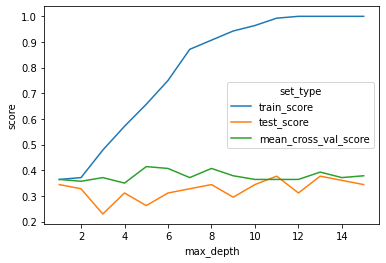

In [17]:
# Разбиваем данные для тренировки и проверки модели
X_titanic_train_deck, X_titanic_test_deck, y_titanic_train_deck, y_titanic_test_deck = train_test_split(X_titanic_deck, y_titanic_deck, test_size=0.3, random_state=10)

for max_depth in range(1, 16):
    titanic_tree_deck = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth) # Создаём

    titanic_tree_deck.fit(X_titanic_train_deck, y_titanic_train_deck)  # Тренируем
    train_score = titanic_tree_deck.score(X_titanic_train_deck, y_titanic_train_deck) # Тестируем

    mean_cross_val_score = cross_val_score(titanic_tree_deck, X_titanic_train_deck, y_titanic_train_deck, cv=5).mean()  # Ещё один крутой метод тестирования

    test_score = titanic_tree_deck.score(X_titanic_test_deck, y_titanic_test_deck)  # Результат угадывания возраста с идеальной точностью

    scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
                                      "mean_cross_val_score": mean_cross_val_score}, ignore_index=True)

# Преобразуем данные для красивой таблички
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'mean_cross_val_score'], var_name="set_type", value_name="score")
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long) # Рисуем красивую табличку

In [18]:
titanic_tree_deck = tree.DecisionTreeClassifier(criterion="entropy", max_depth=6)  # Создаём модель с максимальной эффективностью

titanic_tree_deck.fit(X_titanic_deck, y_titanic_deck)  # Скармливаем весь доступный датасет

titanic_for_test_deck["deck"] = list(titanic_tree_deck.predict(titanic_for_test_deck))

titanic_for_test_deck.deck = titanic_for_test_deck.deck.replace([0, 1, 2, 3, 4, 5, 6], ["A", "B", "C", "D", "E", "F", "G"])  # Меняем название палуб с чисел на буквы

titanic_2 = titanic.copy()  # Копируем датасет оригинальный для мёрджа

# Всю эту лабуду можно сделать и проще, но я не нашёл как
titanic_2 = titanic_2.merge(titanic_for_test_deck[["passenger_id", "deck"]], on="passenger_id", how="left")
titanic.deck.where(~(titanic.deck.isnull()), other=titanic_2.deck_y, inplace=True)

# titanic.loc[titanic.pclass == 3].groupby("deck").agg("deck").count()

In [19]:
print(titanic.isnull().sum(), "\n\n", titanic.shape)  # Проверяем, что все данные на месте (ну почти)

survived        0
pclass          0
sex             0
age             0
sibsp           0
parch           0
fare            0
embarked        2
class           0
who             0
adult_male      0
deck            0
embark_town     2
alive           0
alone           0
passenger_id    0
dtype: int64 

 (891, 16)


In [20]:
# Ура, обучаем третью нейронку, что бы заполнить два "случайно пропавших" города отправления, да, яндекс?

# Снова мы здесь, пояснять шаги уже не буду
scores_data = pd.DataFrame({'max_depth': [], 'train_score': [], 'test_score': [], "mean_cross_val_score": []})

titanic_for_ml_embarked = titanic.copy()

titanic_for_ml_embarked = titanic_for_ml_embarked.drop(["class", "embark_town", "alive", "sibsp", "adult_male", "parch", "fare", "age", "who"], axis=1)

titanic_for_ml_embarked.sex = titanic_for_ml_embarked.sex.replace(["male", "female"], [0, 1])
titanic_for_ml_embarked.deck = titanic_for_ml_embarked.deck.replace(["A", "B", "C", "D", "E", "F", "G"], [0, 1, 2, 3, 4, 5, 6])
titanic_for_ml_embarked.deck = titanic_for_ml_embarked.deck.apply(int)

titanic_for_test_embarked = titanic_for_ml_embarked.loc[titanic_for_ml_embarked.embarked.isnull()]

titanic_for_test_embarked = titanic_for_test_embarked.drop(["embarked"], axis=1)

titanic_for_ml_embarked = titanic_for_ml_embarked.dropna()

titanic_for_ml_embarked.embarked = titanic_for_ml_embarked.embarked.replace(["S", "C", "Q"], [0, 1, 2])
titanic_for_ml_embarked.embarked = titanic_for_ml_embarked.embarked.apply(int)

# Создаём данные для тренировки нейронной сети
X_titanic_embarked = titanic_for_ml_embarked.drop(["embarked"], axis=1)
y_titanic_embarked = titanic_for_ml_embarked.embarked

C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\2142949083.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\2142949083.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\2142949083.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
C:\Users\Niki\AppData\Local\Temp\ipykernel_5216\2142949083.py

<AxesSubplot:xlabel='max_depth', ylabel='score'>

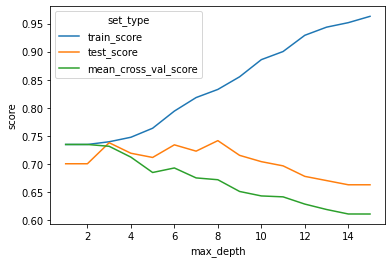

In [21]:
X_titanic_train_embarked, X_titanic_test_embarked, y_titanic_train_embarked, y_titanic_test_embarked = train_test_split(X_titanic_embarked, y_titanic_embarked, test_size=0.3, random_state=10)

for max_depth in range(1, 16):
    titanic_tree_embarked = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth) # Создаём

    titanic_tree_embarked.fit(X_titanic_train_embarked, y_titanic_train_embarked)  # Тренируем
    train_score = titanic_tree_embarked.score(X_titanic_train_embarked, y_titanic_train_embarked) # Тестируем

    mean_cross_val_score = cross_val_score(titanic_tree_embarked, X_titanic_train_embarked, y_titanic_train_embarked, cv=5).mean()

    test_score = titanic_tree_embarked.score(X_titanic_test_embarked, y_titanic_test_embarked)

    scores_data = scores_data.append({'max_depth': max_depth, 'train_score': train_score, "test_score": test_score,
                                      "mean_cross_val_score": mean_cross_val_score}, ignore_index=True)

# Преобразуем данные для красивой таблички
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'mean_cross_val_score'], var_name="set_type", value_name="score")
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long) # Рисуем красивую табличку

In [22]:
titanic_tree_embarked = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)

titanic_tree_embarked.fit(X_titanic_embarked, y_titanic_embarked)

titanic_for_test_embarked["embarked"] = list(titanic_tree_embarked.predict(titanic_for_test_embarked))

titanic_for_test_embarked.embarked = titanic_for_test_embarked.embarked.replace([0, 1, 2], ["S", "C", "Q"])

titanic_2 = titanic.copy()

titanic_2 = titanic_2.merge(titanic_for_test_embarked[["passenger_id", "embarked"]], on="passenger_id", how="left")

titanic.embarked.where(~(titanic.embarked.isnull()), other=titanic_2.embarked_y, inplace=True)

titanic.embark_town.where(~(titanic.embark_town.isnull()), other=titanic.embarked, inplace=True)
titanic.embark_town = titanic.embark_town.replace(["S", "C", "Q"], ['Southampton', 'Cherbourg', 'Queenstown'])

In [23]:
print(titanic.isnull().sum(), "\n\n", titanic.shape)  # ПОБЕДА!!!

survived        0
pclass          0
sex             0
age             0
sibsp           0
parch           0
fare            0
embarked        0
class           0
who             0
adult_male      0
deck            0
embark_town     0
alive           0
alone           0
passenger_id    0
dtype: int64 

 (891, 16)


In [24]:
# Находим количество мужчин и женщин
titanic.groupby("sex").agg("sex").count()

sex
female    314
male      577
Name: sex, dtype: int64

In [25]:
# Проверяем, можно ли доверять столбцу adult_male
titanic.loc[(titanic.adult_male == True) & (titanic.sex != "male")].passenger_id.count(), titanic.loc[(titanic.adult_male == True) & (titanic.age < 16)].passenger_id.count()
# Доверять можно

(0, 0)

In [27]:
# Количество людей в разных классах
titanic.groupby("class").agg("class").count()

class
First     216
Second    184
Third     491
Name: class, dtype: int64

In [28]:
# Странные путешественники (Пятилетняя девочка на 777 индеске в самовольном приключении звучит не очень убедительно) (остальные тоже странно, так как совершеннолетие было с 16 лет)
titanic.loc[titanic.alone == True].sort_values("age").head(6)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,passenger_id
777,1,3,female,5.0,0,0,12.4750,S,Third,child,False,F,Southampton,yes,True,777
731,0,3,male,11.0,0,0,18.7875,C,Third,child,False,D,Cherbourg,no,True,731
780,1,3,female,13.0,0,0,7.2292,C,Third,child,False,F,Cherbourg,yes,True,780
14,0,3,female,14.0,0,0,7.8542,S,Third,child,False,F,Southampton,no,True,14
875,1,3,female,15.0,0,0,7.2250,C,Third,child,False,F,Cherbourg,yes,True,875
22,1,3,female,15.0,0,0,8.0292,Q,Third,child,False,E,Queenstown,yes,True,22


In [45]:
# Странные цены
# Люди в первом классе, заплатившие за проезд 0 фунтов (или натурой, но об этом таблица уже умалчивает))
titanic.sort_values("fare").head(15)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,passenger_id
271,1,3,male,25.0,0,0,0.0,S,Third,man,True,F,Southampton,yes,True,271
597,0,3,male,49.0,0,0,0.0,S,Third,man,True,F,Southampton,no,True,597
302,0,3,male,19.0,0,0,0.0,S,Third,man,True,F,Southampton,no,True,302
633,0,1,male,47.0,0,0,0.0,S,First,man,True,C,Southampton,no,True,633
277,0,2,male,19.0,0,0,0.0,S,Second,man,True,F,Southampton,no,True,277
413,0,2,male,28.0,0,0,0.0,S,Second,man,True,F,Southampton,no,True,413
674,0,2,male,28.0,0,0,0.0,S,Second,man,True,F,Southampton,no,True,674
263,0,1,male,40.0,0,0,0.0,S,First,man,True,B,Southampton,no,True,263
466,0,2,male,28.0,0,0,0.0,S,Second,man,True,F,Southampton,no,True,466
732,0,2,male,39.0,0,0,0.0,S,Second,man,True,F,Southampton,no,True,732


In [56]:
# Люди, заплатившие за третий класс больше 25 фунтов (второй класс стоил от 15, первый от 30 фунтов)
titanic[titanic.pclass == 3].sort_values("fare", ascending=False).head(50)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,passenger_id
324,0,3,male,40.0,8,2,69.5500,S,Third,man,True,F,Southampton,no,False,324
792,0,3,female,18.0,8,2,69.5500,S,Third,woman,False,F,Southampton,no,False,792
180,0,3,female,29.0,8,2,69.5500,S,Third,woman,False,F,Southampton,no,False,180
159,0,3,male,40.0,8,2,69.5500,S,Third,man,True,F,Southampton,no,False,159
201,0,3,male,40.0,8,2,69.5500,S,Third,man,True,F,Southampton,no,False,201
863,0,3,female,19.0,8,2,69.5500,S,Third,woman,False,F,Southampton,no,False,863
846,0,3,male,17.0,8,2,69.5500,S,Third,man,True,F,Southampton,no,False,846
643,1,3,male,20.0,0,0,56.4958,S,Third,man,True,F,Southampton,yes,True,643
169,0,3,male,28.0,0,0,56.4958,S,Third,man,True,D,Southampton,no,True,169
509,1,3,male,26.0,0,0,56.4958,S,Third,man,True,F,Southampton,yes,True,509


In [57]:
# Люди, заплатившие за второй класс больше 60 фунтов (первый класс был от 30 фунтов)
titanic[titanic.pclass == 2].sort_values("fare", ascending=False).head(7)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,passenger_id
665,0,2,male,32.0,2,0,73.5,S,Second,man,True,F,Southampton,no,False,665
72,0,2,male,21.0,0,0,73.5,S,Second,man,True,D,Southampton,no,True,72
385,0,2,male,18.0,0,0,73.5,S,Second,man,True,F,Southampton,no,True,385
120,0,2,male,21.0,2,0,73.5,S,Second,man,True,F,Southampton,no,False,120
655,0,2,male,24.0,2,0,73.5,S,Second,man,True,F,Southampton,no,False,655
615,1,2,female,24.0,1,2,65.0,S,Second,woman,False,F,Southampton,yes,False,615
754,1,2,female,48.0,1,2,65.0,S,Second,woman,False,F,Southampton,yes,False,754


In [53]:
# Заплатил за проезд в первом классе 5 фунтов (Это все пасхалки, которые я должен был найти?)
titanic[titanic.pclass == 1].sort_values("fare").iloc[5]

survived                  0
pclass                    1
sex                    male
age                    33.0
sibsp                     0
parch                     0
fare                    5.0
embarked                  S
class                 First
who                     man
adult_male             True
deck                      B
embark_town     Southampton
alive                    no
alone                  True
passenger_id            872
Name: 872, dtype: object

In [58]:
# В этой таблице только выжившие
titanic_alive = titanic.loc[titanic.survived == 1]

In [59]:
# Изменение процент взрослых мужчин
print("Старый процент живых мужчин:\t\t", titanic.loc[titanic.adult_male == True].passenger_id.count() / titanic.shape[0])
print("Новый процент живых мужчин:\t\t\t", titanic_alive.loc[titanic_alive.adult_male == True].passenger_id.count() / titanic_alive.shape[0])
print("Изменение процента живых мужчин:\t", titanic_alive.loc[titanic_alive.adult_male == True].passenger_id.count() / titanic_alive.shape[0] - titanic.loc[titanic.adult_male == True].passenger_id.count() / titanic.shape[0])

Старый процент живых мужчин:		 0.6026936026936027
Новый процент живых мужчин:			 0.2573099415204678
Изменение процента живых мужчин:	 -0.3453836611731349


In [72]:
bef, aft = list(titanic.groupby("sex").agg("sex").count()), list(titanic_alive.groupby("sex").agg("sex").count())
print("Шанс выжить, если ты женщина:", aft[0] / bef[0])
print("Шанс выжить, если ты мужчина:", aft[1] / bef[1])

Шанс выжить, если ты женщина: 0.7420382165605095
Шанс выжить, если ты мужчина: 0.18890814558058924


In [73]:
bef, aft = list(titanic.groupby("class").agg("class").count()), list(titanic_alive.groupby("class").agg("class").count())
print("Шанс выжить, если плыл в первом классе:", aft[0] / bef[0])
print("Шанс выжить, если был во втором классе:", aft[1] / bef[1])
print("Шанс выжить, если был в третьем классе:", aft[2] / bef[2])

Шанс выжить, если плыл в первом классе: 0.6296296296296297
Шанс выжить, если был во втором классе: 0.47282608695652173
Шанс выжить, если был в третьем классе: 0.24236252545824846


In [74]:
bef, aft = list(titanic.groupby("alone").agg("alone").count()), list(titanic_alive.groupby("alone").agg("alone").count())
print("Шанс выжить, если плыл в компании:", aft[0] / bef[0])
print("Шанс выжить, если плыл в одиночку:", aft[1] / bef[1])

Шанс выжить, если плыл в компании: 0.5056497175141242
Шанс выжить, если плыл в одиночку: 0.30353817504655495
